# Delta Hedging 

Delta hedging is the process of offsetting price flucuations in an options contract by trading in the underlying. In this case, you would buy or sell shares of the underlying stock to offset the price changes in a particular options price.

In this notebook we will investigate the effects of delta hedging a European call option using real data from Apple stocks. We will use the Black Scholes model to price the option and the delta of the option. We will then use the delta to calculate the number of shares of Apple stock we need to buy or sell to offset the price changes in the option. We will then calculate the profit and loss of the option and the hedged position.

Here we will use dataset pulled down by Yahoo finance for the date of 20/07/2023. We will use the closing price of the stock for the day as the spot price for the option.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from _utils import *
from _fitting import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.optimize import brentq

# set backend of matplotlib to seaborn
plt.style.use('seaborn')



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/var/folders/k6/79gt8yds1l3gsjyykhx8fr4r0000gn/T/ipykernel_97954/778567831.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# tickers for the Apple
ticker = "AAPL"
option_ticker = "AAPL"

interval = "1d"
end_date = dt.datetime(2023, 7, 20)
start_date = end_date -  dt.timedelta(days = 300)

# Get yesterdays price data for the S&P 500
data = get_stock_data(ticker, start_date, end_date, interval)
data.index = data.index.date

# get at the money price
S0 = data['Close'].values[-1]
data['log_close'] = np.log(data['Close']/S0)

# Get interest rate
r = get_repo_rate(end_date-dt.timedelta(days=7), end_date).values[0,0]/(100)

# Get some rough estimates of mu and sigma
mu, sigma = estimate_coeffs(data['log_close'], len(data['log_close']), 1)

#---------------------#
Getting underlying data for ticker:  AAPL
#---------------------#
[*********************100%***********************]  1 of 1 completed


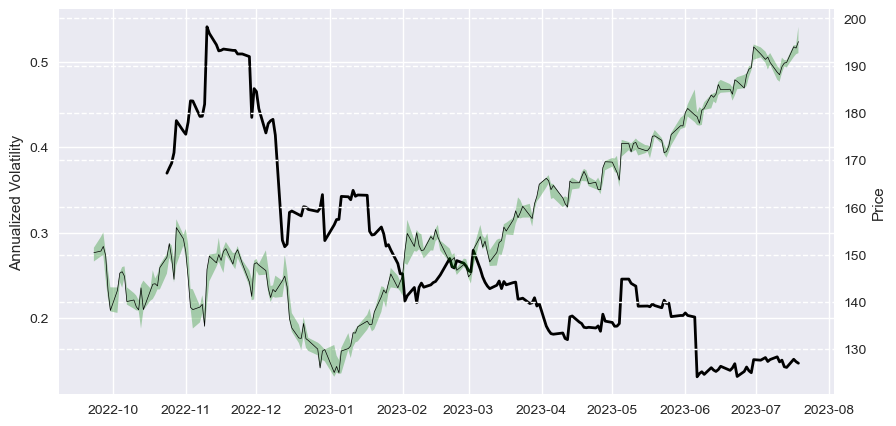

In [3]:
# We now want to get the realised volatility over the last 30 days
data['log_return'] = np.log(data['Close']) - np.log(data['Close'].shift(1))
data['volatility'] = data['log_return'].rolling(21).std() * np.sqrt(252)


fig = plt.figure(figsize=(10, 5))
plt.plot(data['volatility'], color='k', linewidth=2)
plt.ylabel('Annualized Volatility')
# on seperate axis plot the price
ax2 = plt.twinx()
ax2.plot(data['Close'], color='k', linewidth=0.5)
ax2.fill_between(data.index, data['Low'], data['High'], facecolor='g', alpha=0.3)
ax2.set_ylabel('Price')

plt.grid(linestyle='--')
plt.show()

# Get Options data

Here we will be in the business of selling a single option on Apple stock. 

We will use the Black-Scholes formula to calculate the price of the option.  We will then use the delta hedging strategy to hedge the option weekly.  We will then calculate the profit and loss of the option and the hedging strategy.

Recall that a call gives us, the owner the right but not the obligation to purchase the stock at a given price, the strike price, at a given time, the maturity.  The price we pay for this right is the premium.

In [99]:
# get expirey date within tau days of yesterday
trading_days = 252
tau = 92
# Number of trading days
tau_trading = tau - 26
dtau = 5

# interest rate per day
r_t = r/365

expiry_date = (dt.datetime.today() + dt.timedelta(days=tau)).date()

# load in the options data
options = pd.read_csv('./data/options.csv', index_col=0)
    

In [123]:
# get the option that is the closest to the money
idx = np.abs(options.index - 195).argmin()
option = options.iloc[idx]

# We now purchase the option, which controls 100 shares so the price is 
C0 = option['lastPrice']

# get strike price
K = option.name

# we will assume the volatility is the same as the last realised volatility
vol = data['volatility'].values[-1]/(100/tau**0.5)

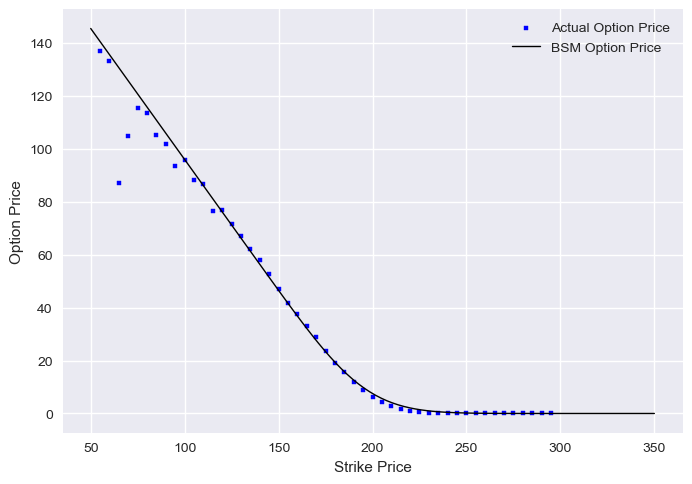

In [131]:
# We will now compare the BSM to the actual options price
K_vals = np.linspace(50, 350, 100)

# Get the call price
call_price = OptionsPriceBSM(S0, K_vals, tau_trading, vol, r_t, option_type='call')

plt.scatter(options.index, options['lastPrice'], color='b', s=10, marker='s', label='Actual Option Price')
plt.plot(K_vals, call_price, color='k', linewidth=1, label='BSM Option Price')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()

plt.show()

In [125]:
def ImpliedVolatilityBSM(S0, K, tau, r, price, option_type="call"):
    """
    Compute the implied volatility of a European option using the Black Scholes Merton model
    using the Brentq method in scipy

    Parameters
    ----------
    S0 : float
        The current stock price
    K : float
        The strike price
    tau : float
        The time to maturity
    sigma : float
        The realised volatility
    r : float
        The risk free rate
    option_type : str
        The type of option. Must be either 'call' or 'put'
    """

    # compute the implied volatility
    implied_vol = brentq(
        lambda x: OptionsPriceBSM(S0, K, tau, x, r, option_type=option_type) - price,
        a=-5,
        b=5,
    )

    return implied_vol

In [128]:
# compute the implied volatility
# implied_vol = ImpliedVolatilityBSM(C0, S0, K, tau_trading, r_t, option_type='call')
idx = np.abs(options.index - 180).argmin()
option = options.iloc[idx]

K = option.name
price = option['lastPrice']
implied_vol_real = option['impliedVolatility']

# compute the implied volatility
implied_vol = ImpliedVolatilityBSM(S0, K, tau, r_t, price, option_type='call')

# brentq??

print(implied_vol)

0.010433524581343856


In [129]:
vol

0.014119793540301398

In [105]:
OptionsPriceBSM(S0, K, tau, vol, r_t, option_type="call")

implied_vol_real


0.2766185620117187

In [106]:
vol*(100/tau_trading**0.5)

0.14720902383314077

In [107]:
# Assuming geometric brownian motion, we can simulate the stock price
# over the next 77 days which is 60 trading days
t = np.arange(10e-4, tau_trading+dtau, dtau) 

# number of trajectories
n = 1
# simulate the stock price assuming no drift
St = stockprice_evolution(S0, t, dtau, -0.00, vol, n)

# define a function that returns greeks using black scholes
Ct = OptionsPriceBSM(St, K, t[::-1], vol, r_t, option_type='call')
deltat = OptionDeltaBSM(St, K, t[::-1], vol, r_t, option_type='call')
deltat = np.round(100*deltat, 0).astype(int)

# Compute evolution of wealth over time
dr = np.exp(r_t*dtau)

In [108]:
def MonteCarloPandL(N, S0, K, t, dtau, r, mu, vol_implied, vol_realised, option_type='call'):
    '''
    Compute the P&L of a delta hedged portfolio using Monte Carlo simulation

    ----------
    Parameters
    ----------
    N: int
        Number of simulations
    S0: float
        Initial stock price
    K: float
        Strike price
    t: array_like
        Time to maturity
    dtau: float
        Time step
    r: float
        Interest rate (per trading day)
    mu: float
        Drift of stock price
    vol: float
        Stock measured Volatility
    option_type: str
        Type of option ('call' or 'put')

    -------
    Returns
    -------
    PnL: array_like
        Profit and loss of the portfolio
    
    '''

    # Compute stock price evolution
    St = stockprice_evolution(S0, t, dtau, mu, vol_realised, N)

    # define a function that returns greeks using black scholes
    Ct = OptionsPriceBSM(St, K, t[::-1], vol_implied, r, option_type)
    deltat = OptionDeltaBSM(St, K, t[::-1], vol_implied, r, option_type)
    deltat = np.round(100*deltat, 0).astype(int)

    # Compute evolution of wealth over time
    dr = np.exp(r*dtau)

    # compute delta adjustments 
    d_delta = np.diff(deltat, axis=1)
    
    # Compute P&L on option
    option_premium = 100*(Ct[:, 0])
    option_interest = 100*Ct[:, 0] * r * t[-1]

    # compute cashfolow adjustments for delta hedging
    cashflow = (-d_delta*St[:, 1:]).sum(axis=1)
    cashflow_interest = cashflow*r*t[-1]

    # Compute profit and loss on stocks hedge
    stock_PandL = (K * deltat[:, -1] - deltat[:, 0] * St[:, 0])

    # interest on intial stock borrowed from the Money market
    stock_interest = -deltat[:, 0] * St[:, 0] * r * t[-1]

    # Sum all P&L
    total_cashflow = option_premium + cashflow + stock_PandL
    total_interest = option_interest + cashflow_interest + stock_interest

    # Return total P&L
    return total_cashflow + total_interest, St


In [109]:
N = 1

K = S0
# Compute stock price evolution
St = stockprice_evolution(S0, t, dtau, 0.000, vol, N)

# define a function that returns greeks using black scholes
Ct = OptionsPriceBSM(St, K, t[::-1], vol, r_t, option_type='call')
deltat = OptionDeltaBSM(St, K, t[::-1], vol, r_t, option_type='call')
deltat = np.round(100*deltat, 0).astype(int)

# Compute evolution of wealth over time
dr = np.exp(r_t*dtau)

# compute delta adjustments 
d_delta = np.diff(deltat, axis=1)

# Compute all P&L

# Compute P&L on option
option_PandL = 100*(Ct[:, 0] - np.maximum(St[:, -1] - K, 0))
option_interest = 100*Ct[:, 0] * r_t* t[-1]

d_cashflow = -d_delta*St[:, 1:]

# compute cashfolow adjustments for delta hedging
cashflow = (-d_delta*St[:, 1:]).sum(axis=1)
cashflow_interest = (-d_delta*St[:, 1:]*(dr-1)).sum(axis=1)

# Compute profit and loss on stocks hedge

stock_PandL = -deltat[:, -1] * K  - deltat[:, 0] * St[:, 0]

# Sum all P&L
total_cashflow = option_PandL + cashflow + stock_PandL
total_interest = option_interest + cashflow_interest 

# Return total P&L
total = total_cashflow + total_interest 


total

array([51.96478494])

In [110]:
# create a dataframe to store the data with index name as week 
df = pd.DataFrame(index=np.arange(len(t)), columns=['Stock Price', 'Delta'])
df.index.name = 'Week'
df['Stock Price'] = St[0]
df['Delta'] = - deltat[0]
df['Delta Adjustments'] = df['Delta'].diff()
df['Total Delta Adjustment'] = df.loc[0, 'Delta'] - df['Delta']
df['Adjustment Cashflow'] = df['Delta Adjustments']*df['Stock Price']
df['Interest on Adjustment'] = df['Adjustment Cashflow']*(dr-1)

# Print the dataframe
df

,Stock Price,Delta,Delta Adjustments,Total Delta Adjustment,Adjustment Cashflow,Interest on Adjustment
Week,,,,,,
0,195.100006,-56,NaN,0,NaN,NaN
1,194.184525,-54,2.0,-2,388.369051,0.270356
2,193.810139,-53,1.0,-3,193.810139,0.134918
3,204.135041,-74,-21.0,18,-4286.835862,-2.984206
4,198.403940,-63,11.0,7,2182.443337,1.519270
5,195.911406,-57,6.0,1,1175.468433,0.818282
6,195.706279,-56,1.0,0,195.706279,0.136238
7,185.027937,-26,30.0,-30,5550.838120,3.864119
8,189.123879,-35,-9.0,-21,-1702.114914,-1.184898


In [111]:
PandL = 100*Ct[0, 0]
options_interest = 100*Ct[0, 0] * r_t*tau_trading

cashflow = df['Adjustment Cashflow'].sum()
cashflow_interest = df['Interest on Adjustment'].sum()

# original stock p and l
stock_panl =  - (K * df['Delta'].values[-1] - df['Stock Price'].values[0] * df['Delta'].values[0])
# stock_panl = -df['Delta'].values[0] *( df['Stock Price'].values[-1] -  df['Stock Price'].values[0])
stock_interest = (df['Delta'].values[0])*(S0) * r_t*tau_trading

total_cashflow = PandL + cashflow + stock_panl
total_interest = options_interest + cashflow_interest 
total = total_cashflow + total_interest

print(f'Original P&L: {PandL:.2f}')
print(f'Stock P&L: {stock_panl:.2f}')
print(f'Adjustment P&L: {cashflow:.2f}')

print(f'Interest on Original P&L: {options_interest:.2f}')
print(f'Interest on Stock P&L: {stock_interest:.2f}')
print(f'Interest on Cashflow: {cashflow_interest:.2f}')

print(f'Total P&L: {total:.2f}')


Original P&L: 872.95
Stock P&L: -10925.60
Adjustment P&L: 10089.09
Interest on Original P&L: 8.02
Interest on Stock P&L: -100.36
Interest on Cashflow: 7.02
Total P&L: 51.48


In [112]:
PanL, St = MonteCarloPandL(10000, S0, S0, t, dtau, r_t, 0.00, vol, vol, option_type='call')

# Compute mean and standard deviation of P&L
mean = PanL.mean()
std = PanL.std()

# compute 95% confidence interval
conf_int = np.percentile(PanL, [2.5, 97.5])

# compute probbility of loss
prob_loss = np.sum(PanL < 0)/len(PanL)

print(f'P&L mean: {mean:.2f}')
print(f'P&L std: {std:.2f}')
print(f'P&L 95% confidence interval: {conf_int}')
print(f'Probability of loss: {prob_loss:.2f}')

P&L mean: 2.42
P&L std: 186.89
P&L 95% confidence interval: [-388.46706525  383.48540961]
Probability of loss: 0.49


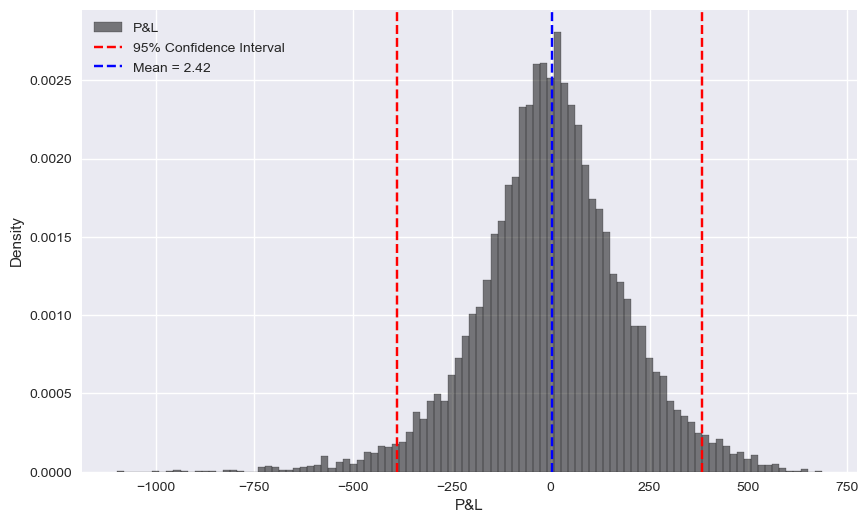

In [113]:
fig = plt.figure(figsize=(10, 6))

plt.hist(PanL, bins=100, density=True, label='P&L', color='k', alpha=0.5, edgecolor='k')

plt.axvline(conf_int[0], color='r', linestyle='--', label='95% Confidence Interval')
plt.axvline(conf_int[1], color='r', linestyle='--')
plt.axvline(mean, color='b', linestyle='--', label='Mean = {:.2f}'.format(mean))
plt.xlabel('P&L')
plt.ylabel('Density')

plt.legend()


plt.show()

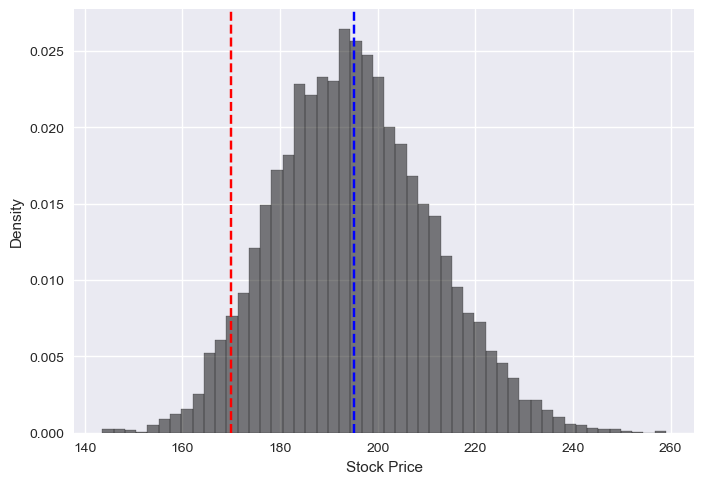

In [1865]:
plt.hist(St[:, -1], bins=50, density=True, label='Stock Price', color='k', alpha=0.5, edgecolor='k')
plt.axvline(K, color='r', linestyle='--', label='Strike Price')
plt.axvline(S0, color='b', linestyle='--', label='Initial Stock Price')
plt.xlabel('Stock Price')
plt.ylabel('Density')
plt.show()